Цель - предсказать пол клиента по транзакциям.

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import seaborn as sns
import matplotlib
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [100]:
!git clone https://github.com/alexey9019/data.git

fatal: destination path 'data' already exists and is not an empty directory.


In [0]:
tr_mcc_codes = pd.read_csv('/content/data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('/content/data/tr_types.csv', sep=';', index_col='tr_type')
transactions = pd.read_csv('/content/data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('/content/data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('/content/data/gender_test.csv', index_col='customer_id')

transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [0]:
# создадим функции для построения классификатора 
# оценим результаты и построим прогноз для тестовых пользователей
# cv_score - cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res = xgb.cv(params, xgb.DMatrix(train, y_true),
               early_stopping_rounds=10, maximize=True, 
               num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                     cv_res.loc[index_argmax]['test-auc-std'],
                                                                     index_argmax))

# построим модель и выведем результаты классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names = list(train.columns)), 
              num_boost_round = num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names = list(train.columns)))
    submission = pd.DataFrame(index = test.index, data = y_pred, columns = ['probability'])
    return clf, submission

# отобразим важность переменной
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key = lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='red')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.title('Важность переменной', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [0]:
# зададим параметры
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [0]:
# используем медиану, среднеквадратичное отклонение и количество
def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation_basic)

In [105]:
# выведем результат
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.611+-0.064, Trees: 50


In [0]:
# результат классификации тестовых пользователей
clf, submission = fit_predict(params, 70, data_train, data_test, target)

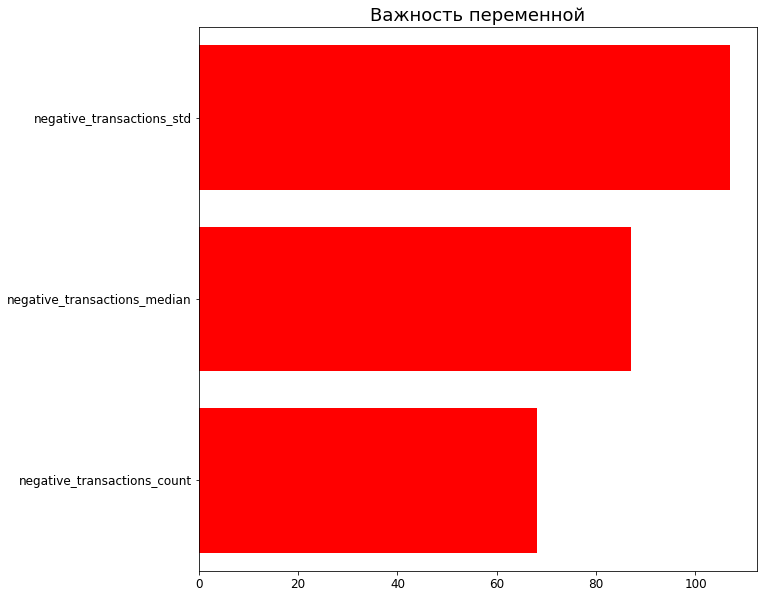

In [107]:
# отобразим важность переменной
draw_feature_importances(clf, 10)

In [0]:
# сохраним в файл
submission.to_csv('/content/data/basic_features_submission.csv')

In [0]:
# используем данные о том, где совершались транзакции (mcc_code)
# предполагаем, что мужчины чаще будут покупать цветы (mcc_code 5992 - флористика)
for df in [transactions_train, transactions_test]:
    df['mcc_code'] == 5992
    df['mcc'] = df['mcc_code']

In [0]:
# используем медиану, среднеквадратичное отклонение и количество
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['mcc_code'].value_counts(normalize = True).add_prefix('mcc_code_')))
    features.append(pd.Series(x['mcc'].value_counts(normalize = True).add_prefix('mcc_')))
    
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    
    return pd.concat(features)

In [0]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .apply(features_creation_advanced).unstack(-1)

In [112]:
# выведем результат
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.808+-0.075, Trees: 38


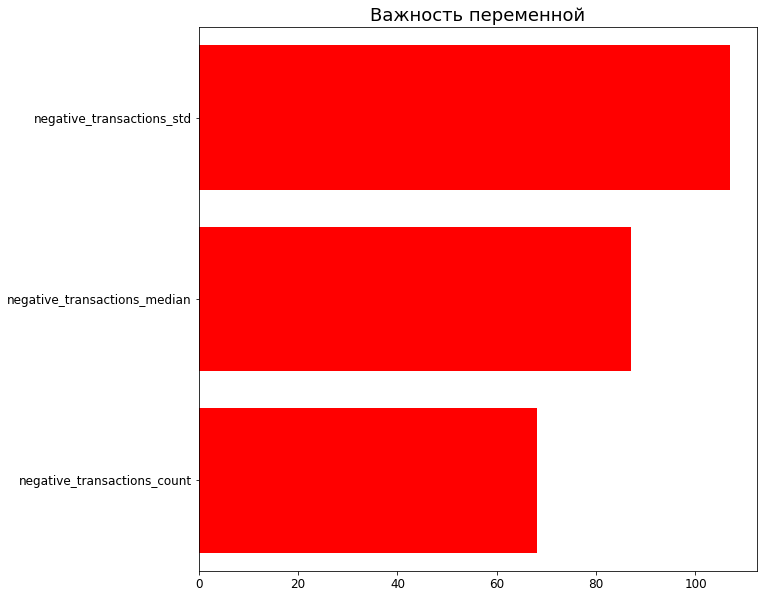

In [113]:
# отобразим важность переменной
draw_feature_importances(clf, 10)

In [0]:
# сохраним в файл
submission.to_csv('/content/data/submission_advanced.csv')

In [115]:
transactions_train.describe()

,mcc_code,tr_type,amount,gender,mcc
count,61439.000000,61439.000000,6.143900e+04,61439.000000,61439.000000
mean,5582.150865,2191.452595,-3.023813e+04,0.552808,5582.150865
std,617.691250,2015.563063,5.055619e+05,0.497207,617.691250
min,1711.000000,1010.000000,-5.140376e+07,0.000000,1711.000000
25%,5331.000000,1010.000000,-2.919691e+04,0.000000,5331.000000
50%,5541.000000,1110.000000,-7.905620e+03,1.000000,5541.000000
75%,6010.000000,2011.000000,-2.245920e+03,1.000000,6010.000000
max,9399.000000,8145.000000,3.593465e+07,1.000000,9399.000000


In [116]:
transactions_train.dtypes

tr_datetime     object
mcc_code         int64
tr_type          int64
amount         float64
term_id         object
gender           int64
mcc              int64
dtype: object

In [117]:
transactions_train['gender'].value_counts()

1    33964
0    27475
Name: gender, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4317583eb8>,
      dtype=object)

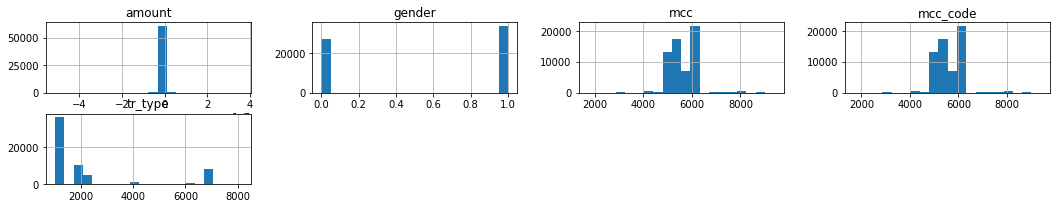

In [118]:
transactions_train.hist(figsize=(18, 8), layout=(5,4), bins=20)

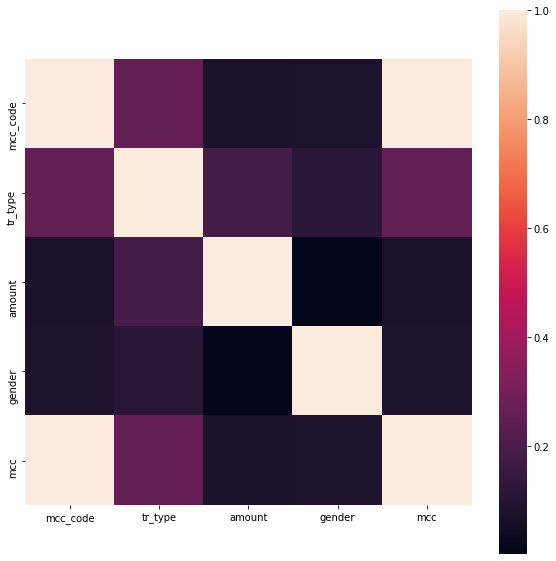

In [119]:
plt.subplots(figsize=(10,10))
sns.heatmap(transactions_train.corr(), square=True)
plt.show()

In [120]:
y = transactions_train['gender'].map({True: 1, False: 0}).values
transactions_train.drop(['gender'], axis = 1, inplace=True)
y

array([0, 0, 0, ..., 1, 1, 1])

In [121]:
transactions_train.drop(['tr_datetime', 'term_id'], axis = 1, inplace=True)
X = transactions_train.values.astype(np.float)
X

array([[  5411.  ,   1110.  ,  -5773.35,   5411.  ],
       [  6011.  ,   2010.  , -11229.58,   6011.  ],
       [  6011.  ,   2010.  , -67377.47,   6011.  ],
       ...,
       [  5211.  ,   1110.  , -10106.62,   5211.  ],
       [  5499.  ,   1010.  , -16709.61,   5499.  ],
       [  5311.  ,   1110.  , -17015.06,   5311.  ]])

In [122]:
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.27708383, -0.53655547,  0.04839166, -0.27708383],
       [ 0.69428315, -0.09002649,  0.03759917,  0.69428315],
       [ 0.69428315, -0.09002649, -0.07346212,  0.69428315],
       ...,
       [-0.60087282, -0.53655547,  0.0398204 , -0.60087282],
       [-0.13461667, -0.58616981,  0.02675959, -0.13461667],
       [-0.43897833, -0.53655547,  0.02615541, -0.43897833]])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=42)

In [124]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 100), dtype='int')}
gs = GridSearchCV(knn, knn_grid, cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,

In [0]:
def grid_plot(x, y, x_label, title, y_label='accuracy'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

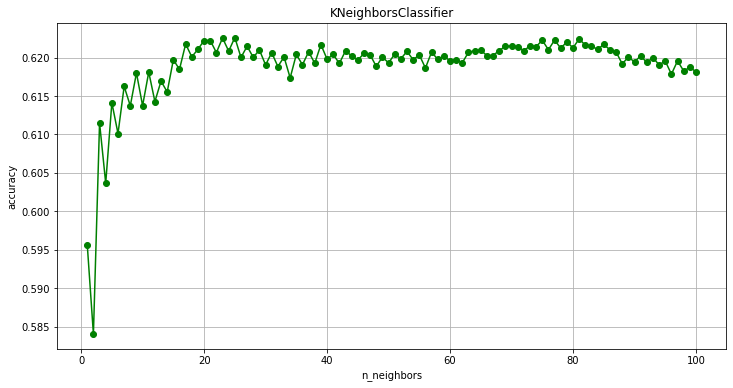

In [126]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [127]:
print(gs.best_params_, gs.best_score_)

{'n_neighbors': 25} 0.6226183865346686


In [0]:
knn = KNeighborsClassifier(n_neighbors=25) 
clf_knn = knn.fit(X_train, y_train)

In [129]:
y_knn = clf_knn.predict(X_test)
y_knn

array([1, 0, 0, ..., 0, 1, 1])

In [130]:
print(sklearn.metrics.classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      4066
           1       0.66      0.67      0.66      5150

    accuracy                           0.62      9216
   macro avg       0.62      0.62      0.62      9216
weighted avg       0.62      0.62      0.62      9216



In [131]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [132]:
predictions = regr.predict(X_test)
predictions

array([0.56954288, 0.53902531, 0.5690546 , ..., 0.5690546 , 0.69258976,
       0.5143671 ])

(array([0.04901961, 0.00816993, 0.10620915, 2.17728758, 7.10784314,
        3.08006536, 3.61928105, 0.31862745, 0.31862745, 0.39624183,
        0.44117647, 3.39460784, 0.02042484, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.02042484, 0.00816993, 0.19199346,
        0.00816993, 2.5122549 , 6.94444444, 1.99754902, 3.05147059,
        0.09803922, 0.17156863, 0.14705882, 1.09477124, 0.36356209]),
 array([-0.60819149, -0.58162899, -0.55506649, -0.52850399, -0.50194149,
        -0.47537899, -0.44881649, -0.42225399, -0.39569149, -0.36912899,
        -0.34256649, -0.31600399, -0.28944149, -0.26287899, -0.23631649,
        -0.20975399, -0.18319149, -0.15662899, -0.13006649, -0.10350399,
        -0.07694149, -0.05

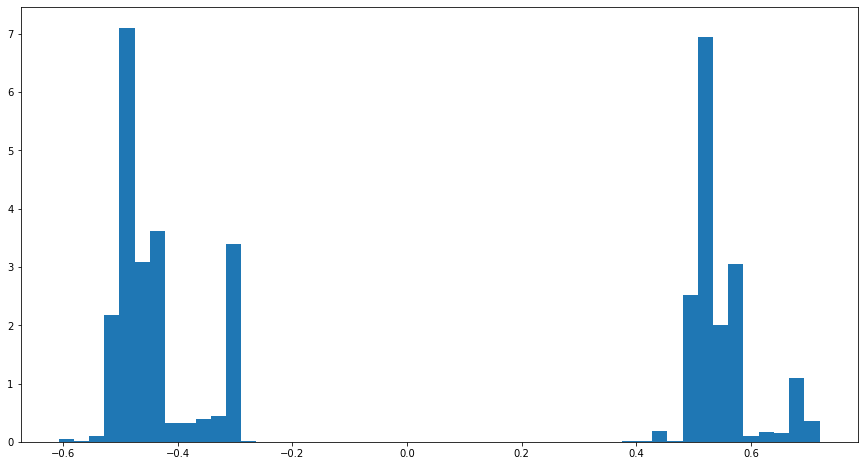

In [133]:
rem = predictions - y_test
plt.figure(figsize=(15, 8))
plt.hist(rem, bins=50, normed=True)

In [134]:
r2 = sklearn.metrics.r2_score(y_test, predictions)

print(f"R2 score / LR = {r2}")

R2 score / LR = 0.020502199419660805


In [135]:
mae = sklearn.metrics.median_absolute_error(y_test, predictions)

print (f"MAE {mae}")

MAE 0.48612117783769404


In [0]:
clf_knn = KNeighborsClassifier(n_neighbors=29).fit(X_train, y_train)

In [0]:
y_knn = clf_knn.predict(X_test)

ROC AUC = 0.6208


Text(0.5, 0, 'False Positive Rate')

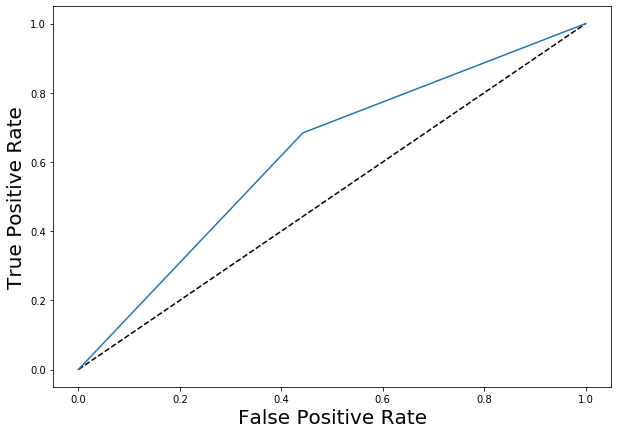

In [138]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_knn)
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
print ('ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr)))
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)

In [139]:
grid={"C": np.logspace(-2, 4, 20), "penalty":["l1","l2"] }
logreg =LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5)
logreg_cv.fit(X, y)

logreg_cv.best_params_, logreg_cv.best_score_

({'C': 0.01, 'penalty': 'l2'}, 0.5596608017708622)

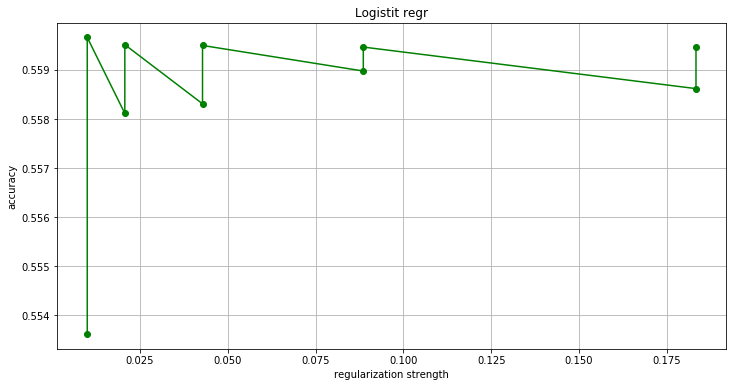

In [140]:
grid_plot(logreg_cv.cv_results_['param_C'][:10], logreg_cv.cv_results_['mean_test_score'][:10], 'regularization strength', 'Logistit regr')

In [141]:
param_grid = {'min_samples_split': [i for i in range(70, 100, 2)],
              'max_depth': [i for i in range(10, 15)],
              'min_samples_leaf':[i for i in range(2, 6)]}
tree = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5)
tree.fit(X, y)
tree.best_params_, tree.best_score_

({'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 92},
 0.5641042334673416)

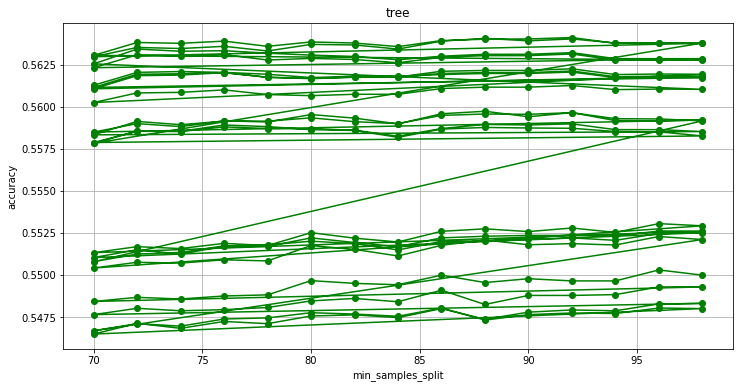

In [142]:
grid_plot(np.array(tree.cv_results_['param_min_samples_split']), tree.cv_results_['mean_test_score'], 'min_samples_split', 'tree')

In [143]:
param_grid = {'max_depth': [i for i in range(2, 15)],
              'min_samples_split': [i for i in range(2, 10)],
              'max_features': [2, len(X[0])-1]
              }

gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
gs.fit(X, y)

print()
gs.best_params_, gs.best_score_

({'max_depth': 7, 'max_features': 2, 'min_samples_split': 3},
 0.5832777226191832)